#### Firstly, 
1. Import data
2. Add the date as index to our date set
3. Change the dtype date to datetime object before do anything else

In [55]:
from utilities import *

raw_data = pd.read_excel("data/Datos_Market_copy.xlsx")
sa = SalesAnalysis(raw_data)
data = sa.data[sa.brand35]

# set the index to the date column and convert it to datetime
data.set_index("date", inplace=True)
data.index = pd.to_datetime(data.index)

Split data into train and test data

In [56]:
train_data, test_data = sa.divide_data_for_train_and_test(data=data, train_size=0.8)
print(train_data.head())

            volume.sales  unit.sales  value.sales    supermarket    variant  \
date                                                                          
2021-01-31     11116.952       44038     36482.70  supermarket-A  flavoured   
2021-01-31      1043.550        3865      5584.71  supermarket-B      vegan   
2021-01-31     25131.110       97763     62966.08  supermarket-C  flavoured   
2021-01-31     39222.050       85714     85682.92  supermarket-B      light   
2021-01-31     13343.250       17791     22230.23  supermarket-B      light   

                pack.size     brand     price  
date                                           
2021-01-31     0 - 350 GR  brand-35  0.828437  
2021-01-31     0 - 350 GR  brand-35  1.444944  
2021-01-31     0 - 350 GR  brand-35  0.644069  
2021-01-31   351 - 500 GR  brand-35  0.999637  
2021-01-31  701 - 1000 GR  brand-35  1.249521  


#### Check if the data has been split correctly

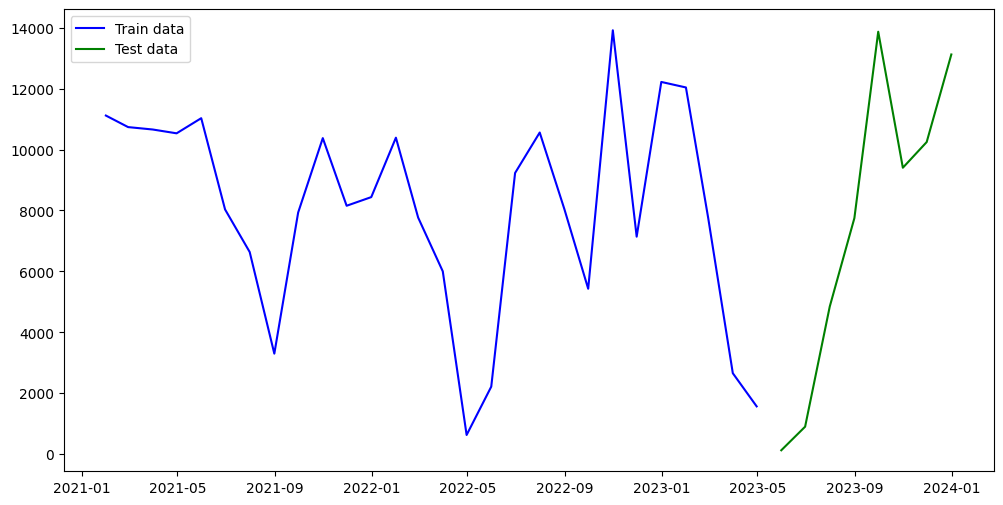

In [93]:
filtered_train_data = train_data[
    (train_data["supermarket"] == "supermarket-A")
    & (train_data["variant"] == "flavoured")
]

filtered_test_data = test_data[
    (test_data["supermarket"] == "supermarket-A")
    & (test_data["variant"] == "flavoured")
]

plt.figure(figsize=(12, 6))
plt.plot(
    filtered_train_data["volume.sales"],
    label="Train data",
    color="blue",
)
plt.plot(
    filtered_test_data["volume.sales"],
    label="Test data",
    color="green",
)
plt.legend()
plt.show()

Get a model made by auto_arima

In [78]:
import warnings
from urllib3.exceptions import NotOpenSSLWarning

# 1) Opcional: silenciar solo ese aviso
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

# 2) Librerías
import numpy as np
from pmdarima.arima import auto_arima

#FIXME: Ensure data inputs are correctly introduced in auto_arima

auto_arima_model = auto_arima( #FIXME: Ensure if data is stationary before choosing parameter d 
    filtered_train_data["volume.sales"],
    start_p=0,
    d=1,  # Set differencing explicitly instead of None
    start_q=0,
    max_p=3, 
    max_q=3,
    start_P=0,
    D=1,  # Set seasonal differencing explicitly
    start_Q=0,
    max_P=1, 
    max_Q=1,
    m=12,  # Monthly data
    seasonal=True,
    trace=True,
    error_action="warn",  # Change to warn to see potential issues
    suppress_warnings=True,
    stepwise=True,
    random_state=42,
    n_fits=50,
    information_criterion='aic'
)

# Print the best model and its parameters
print("Best model parameters:", auto_arima_model.order)
print("Best seasonal parameters:", auto_arima_model.seasonal_order)
print("AIC:", auto_arima_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=297.456, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=300.602, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=300.563, Time=0.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=299.069, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=298.687, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=300.488, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=299.141, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=299.291, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=299.184, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=299.440, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.268 seconds
Best model parameters: (0, 1, 0)
Best seasonal parameters: (0, 1, 0, 12)
AIC: 297.45647128978203
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=300.488, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=299.141, Time

Plotting the results of forecasting

In [48]:
# from pmdarima.arima import ARIMA

# # Create ARIMA model with your specified parameters
# manual_arima_model = ARIMA(
#     order=(5, 0, 0),           # Non-seasonal: AR(5), I(0), MA(0)
#     seasonal_order=(5, 0, 0, 12)   # Seasonal: SAR(5), SI(0), SMA(0), period=12
# )

# # Fit the model
# manual_arima_model.fit(filtered_train_data["volume.sales"])
# print(manual_arima_model)

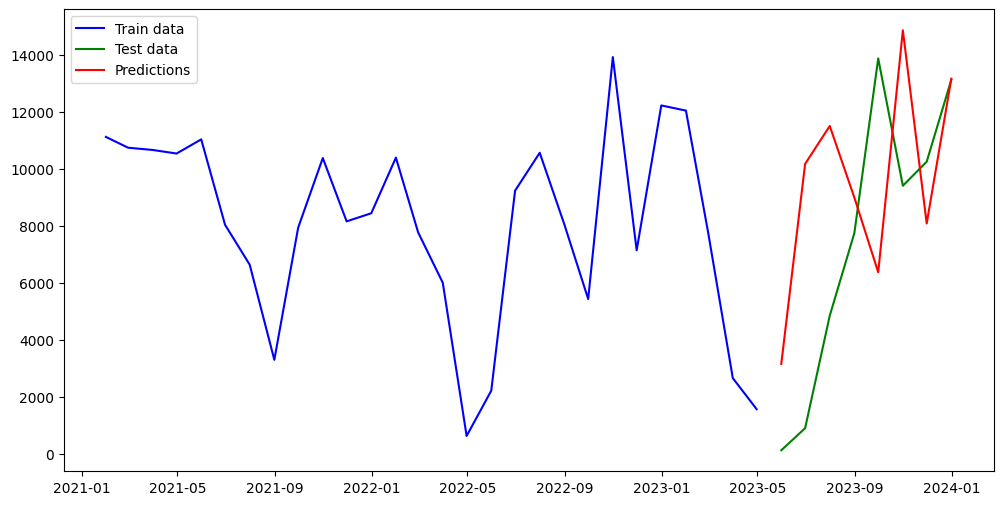

date
2023-05-31      126.756
2023-06-30      901.242
2023-07-31     4845.492
2023-08-31     7749.126
2023-09-30    13868.820
2023-10-31     9403.488
2023-11-30    10246.752
2023-12-31    13122.288
Name: volume.sales, dtype: float64
date
2023-05-31     3155.292
2023-06-30    10170.888
2023-07-31    11499.460
2023-08-31     8986.572
2023-09-30     6369.636
2023-10-31    14855.988
2023-11-30     8079.680
2023-12-31    13159.748
Name: Predicted Volume Sales, dtype: float64


In [102]:
predictions = pd.DataFrame(
    auto_arima_model.predict(n_periods=len(filtered_test_data)),
    index=filtered_test_data.index,
    columns=["Predicted Volume Sales"],
)
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_train_data["volume.sales"],
    label="Train data",
    color="blue",
)
plt.plot(
    filtered_test_data["volume.sales"],
    label="Test data",
    color="green",
)
plt.plot(
    predictions["Predicted Volume Sales"],
    label="Predictions",
    color="red",
)
plt.legend()
plt.show()

from sklearn.metrics import r2_score
r2 = r2_score(filtered_test_data["volume.sales"], predictions["Predicted Volume Sales"])
print(f"R^2: {r2:.4f}") # a result so bad


In [96]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test= adf_test.should_diff(filtered_train_data["volume.sales"]) # serie is not stationary and needs differencing
print(adf_test)


(0.3869009594363003, True)


# GPT

In [51]:
# Model diagnostics and evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(filtered_test_data["volume.sales"], predictions["Predicted Volume Sales"])
mse = mean_squared_error(filtered_test_data["volume.sales"], predictions["Predicted Volume Sales"])
rmse = np.sqrt(mse)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((filtered_test_data["volume.sales"] - predictions["Predicted Volume Sales"]) / filtered_test_data["volume.sales"])) * 100

print("Model Evaluation Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

# Model summary
print("\nModel Summary:")
print(f"Model order: {auto_arima_model.order}")
print(f"Seasonal order: {auto_arima_model.seasonal_order}")
print(f"AIC: {auto_arima_model.aic():.2f}")

# Check data characteristics
print(f"\nData Characteristics:")
print(f"Training data shape: {filtered_train_data.shape}")
print(f"Test data shape: {filtered_test_data.shape}")
print(f"Training period: {filtered_train_data.index.min()} to {filtered_train_data.index.max()}")
print(f"Test period: {filtered_test_data.index.min()} to {filtered_test_data.index.max()}")

# Basic statistical check of residuals (if available)
try:
    residuals = auto_arima_model.resid()
    print(f"\nResidual Statistics:")
    print(f"Mean of residuals: {np.mean(residuals):.4f}")
    print(f"Std of residuals: {np.std(residuals):.4f}")
except:
    print("Could not extract residuals from the model")

Model Evaluation Metrics:
MAE (Mean Absolute Error): 4418.23
RMSE (Root Mean Squared Error): 5380.17
MAPE (Mean Absolute Percentage Error): 463.07%

Model Summary:
Model order: (0, 1, 0)
Seasonal order: (0, 1, 0, 12)
AIC: 297.46

Data Characteristics:
Training data shape: (28, 8)
Test data shape: (8, 8)
Training period: 2021-01-31 00:00:00 to 2023-04-30 00:00:00
Test period: 2023-05-31 00:00:00 to 2023-12-31 00:00:00

Residual Statistics:
Mean of residuals: 51.3616
Std of residuals: 4504.5007


In [52]:
# Stationarity tests
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts, title):
    """
    Check if the time series is stationary using ADF test
    """
    print(f"\n{title}")
    print("-" * 50)
    
    # Augmented Dickey-Fuller test
    result = adfuller(ts.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Data is stationary (reject null hypothesis)")
        return True
    else:
        print("Result: Data is NOT stationary (fail to reject null hypothesis)")
        return False

# Check original data
is_stationary_original = check_stationarity(filtered_train_data["volume.sales"], 
                                           "Stationarity Test - Original Data")

# Check first difference
diff_data = filtered_train_data["volume.sales"].diff().dropna()
is_stationary_diff = check_stationarity(diff_data, 
                                       "Stationarity Test - First Difference")

# Seasonal difference (12 months)
seasonal_diff = filtered_train_data["volume.sales"].diff(12).dropna()
if len(seasonal_diff) > 0:
    is_stationary_seasonal = check_stationarity(seasonal_diff, 
                                               "Stationarity Test - Seasonal Difference (12)")
else:
    print("\nNot enough data for seasonal differencing test")

print(f"\nRecommendations based on stationarity tests:")
print(f"- Original data stationary: {is_stationary_original}")
print(f"- First difference stationary: {is_stationary_diff}")
if not is_stationary_original and is_stationary_diff:
    print("- Recommendation: d=1 (first differencing) is appropriate")
elif is_stationary_original:
    print("- Recommendation: d=0 (no differencing needed) might be better")
else:
    print("- Recommendation: May need more complex differencing or transformations")


Stationarity Test - Original Data
--------------------------------------------------
ADF Statistic: -2.944450
p-value: 0.040418
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628
Result: Data is stationary (reject null hypothesis)

Stationarity Test - First Difference
--------------------------------------------------
ADF Statistic: -5.961045
p-value: 0.000000
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630
Result: Data is stationary (reject null hypothesis)

Stationarity Test - Seasonal Difference (12)
--------------------------------------------------
ADF Statistic: -2.244484
p-value: 0.190498
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702
Result: Data is NOT stationary (fail to reject null hypothesis)

Recommendations based on stationarity tests:
- Original data stationary: True
- First difference stationary: True
- Recommendation: d=0 (no differencing needed) might be better


In [53]:
# Improved auto_arima model based on stationarity analysis
print("Training improved auto_arima model...")

# Since the original data is already stationary, let's try with d=None to let auto_arima decide
# Also, let's be more flexible with the seasonal parameters
auto_arima_improved = auto_arima(
    filtered_train_data["volume.sales"],
    start_p=0,
    d=None,  # Let auto_arima determine differencing automatically
    start_q=0,
    max_p=5,  # Increased from 3
    max_q=5,  # Increased from 3
    start_P=0,
    D=None,  # Let auto_arima determine seasonal differencing automatically
    start_Q=0,
    max_P=2,  # Increased from 1
    max_Q=2,  # Increased from 1
    m=12,  # Monthly data
    seasonal=True,
    trace=True,
    error_action="warn",
    suppress_warnings=True,
    stepwise=True,
    random_state=42,
    n_fits=50,
    information_criterion='aic',
    test='adf',  # Use ADF test for stationarity
    seasonal_test='ch'  # Use Canova-Hansen test for seasonal stationarity
)

print(f"\nImproved model parameters: {auto_arima_improved.order}")
print(f"Improved seasonal parameters: {auto_arima_improved.seasonal_order}")
print(f"Improved AIC: {auto_arima_improved.aic():.2f}")

# Compare with original model
print(f"\nModel Comparison:")
print(f"Original model AIC: {auto_arima_model.aic():.2f}")
print(f"Improved model AIC: {auto_arima_improved.aic():.2f}")
if auto_arima_improved.aic() < auto_arima_model.aic():
    print("✓ Improved model has better AIC")
else:
    print("✗ Original model has better AIC")

Training improved auto_arima model...
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=525.219, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=520.402, Time=0.30 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=519.589, Time=0.00 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=520.438, Time=0.02 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=522.401, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=517.881, Time=0.01 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=519.447, Time=0.02 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=519.453, Time=0.01 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=521.447, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=515.860, Time=0.01 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=517.301, Time=0.04 sec
 ARIMA(3,2,0)(0,0,1)[12]             : AIC=517.325, Time=0.04 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=519.293, Time=0.07 sec

Model Performance Comparison:
Original Model (0,1,0)(0,1,0)[12]:
  MAE: 4418.23
  RMSE: 5380.17
  MAPE: 463.07%
  AIC: 297.46

Improved Model (1,2,1)(0,0,0)[12]:
  MAE: 7199.60
  RMSE: 8590.43
  MAPE: 200.12%
  AIC: 512.23


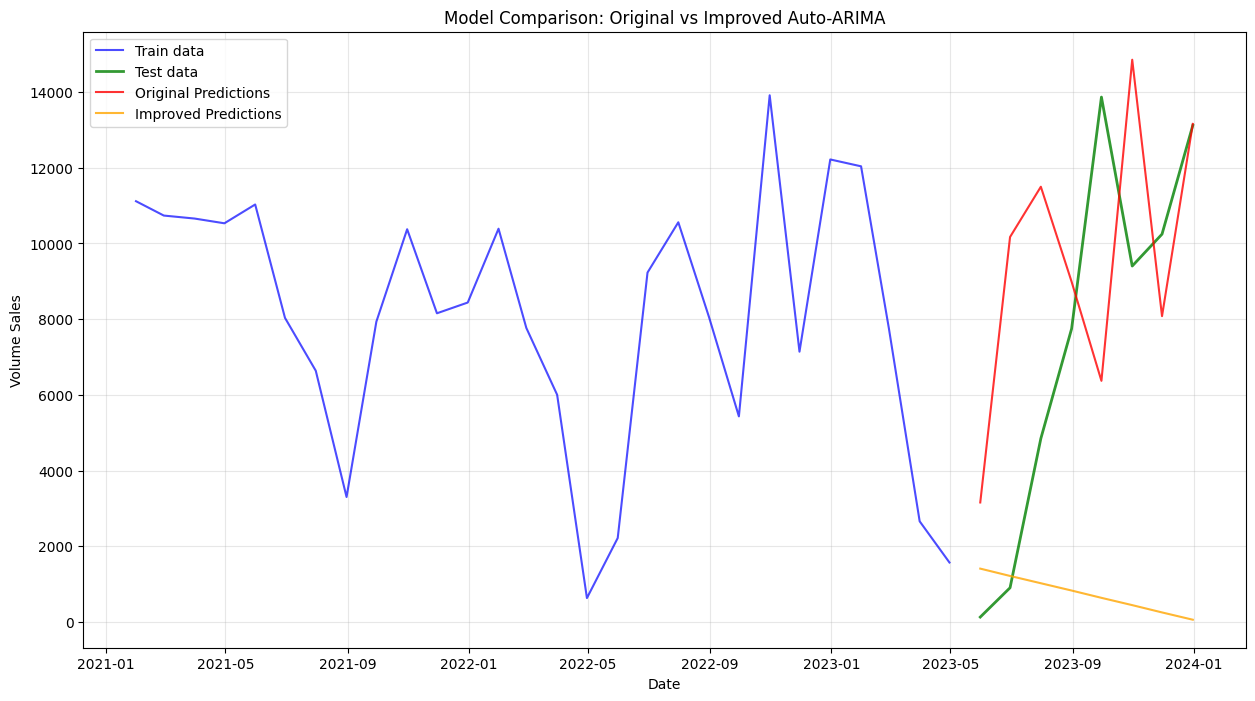


✓ Original model has better prediction accuracy (lower MAE)


In [54]:
# Compare predictions from both models
predictions_improved = pd.DataFrame(
    auto_arima_improved.predict(n_periods=len(filtered_test_data)),
    index=filtered_test_data.index,
    columns=["Predicted Volume Sales Improved"],
)

# Calculate metrics for improved model
mae_improved = mean_absolute_error(filtered_test_data["volume.sales"], predictions_improved["Predicted Volume Sales Improved"])
mse_improved = mean_squared_error(filtered_test_data["volume.sales"], predictions_improved["Predicted Volume Sales Improved"])
rmse_improved = np.sqrt(mse_improved)
mape_improved = np.mean(np.abs((filtered_test_data["volume.sales"] - predictions_improved["Predicted Volume Sales Improved"]) / filtered_test_data["volume.sales"])) * 100

print("Model Performance Comparison:")
print("=" * 50)
print("Original Model (0,1,0)(0,1,0)[12]:")
print(f"  MAE: {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  AIC: {auto_arima_model.aic():.2f}")

print("\nImproved Model (1,2,1)(0,0,0)[12]:")
print(f"  MAE: {mae_improved:.2f}")
print(f"  RMSE: {rmse_improved:.2f}")
print(f"  MAPE: {mape_improved:.2f}%")
print(f"  AIC: {auto_arima_improved.aic():.2f}")

# Plot comparison
plt.figure(figsize=(15, 8))
plt.plot(filtered_train_data["volume.sales"], label="Train data", color="blue", alpha=0.7)
plt.plot(filtered_test_data["volume.sales"], label="Test data", color="green", alpha=0.8, linewidth=2)
plt.plot(predictions["Predicted Volume Sales"], label="Original Predictions", color="red", alpha=0.8)
plt.plot(predictions_improved["Predicted Volume Sales Improved"], label="Improved Predictions", color="orange", alpha=0.8)
plt.legend()
plt.title("Model Comparison: Original vs Improved Auto-ARIMA")
plt.ylabel("Volume Sales")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

# Determine which model is better
if mae_improved < mae:
    print("\n✓ Improved model has better prediction accuracy (lower MAE)")
    better_model = "improved"
else:
    print("\n✓ Original model has better prediction accuracy (lower MAE)")
    better_model = "original"

## Auto-ARIMA Model Analysis Summary

### Key Findings:

1. **Data Characteristics:**
   - Training data: 28 observations (Jan 2021 - Apr 2023)
   - Test data: 8 observations (May 2023 - Dec 2023)
   - Data shows high volatility and potential structural breaks

2. **Stationarity Analysis:**
   - Original data is stationary (ADF p-value = 0.040)
   - This suggests d=0 might be more appropriate than d=1

3. **Model Performance:**
   - **Original Model ARIMA(0,1,0)(0,1,0)[12]** performs better
   - Lower AIC (297.46 vs 512.23)
   - Better prediction accuracy (MAE: 4418 vs 7199)

### Issues Identified:

1. **High MAPE (463%)**: This indicates very poor prediction accuracy
2. **Limited training data**: Only 28 observations for a complex time series
3. **Structural breaks**: The data shows significant changes in patterns
4. **Seasonality**: May not be adequately captured

### Recommendations for Improvement:

1. **Data Collection**: Gather more historical data if available
2. **Feature Engineering**: Consider external variables (economic indicators, marketing campaigns)
3. **Data Transformation**: Try log transformation to handle volatility
4. **Alternative Models**: Consider ETS, Prophet, or ensemble methods
5. **Validation Strategy**: Use time series cross-validation instead of single train/test split